In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from IPython.display import clear_output
import imageio
import time
import gc
import os

from tqdm import tqdm
import networkx as nx

Graph density = 0.5987987987987987 %.
(1000, 1000)
[0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

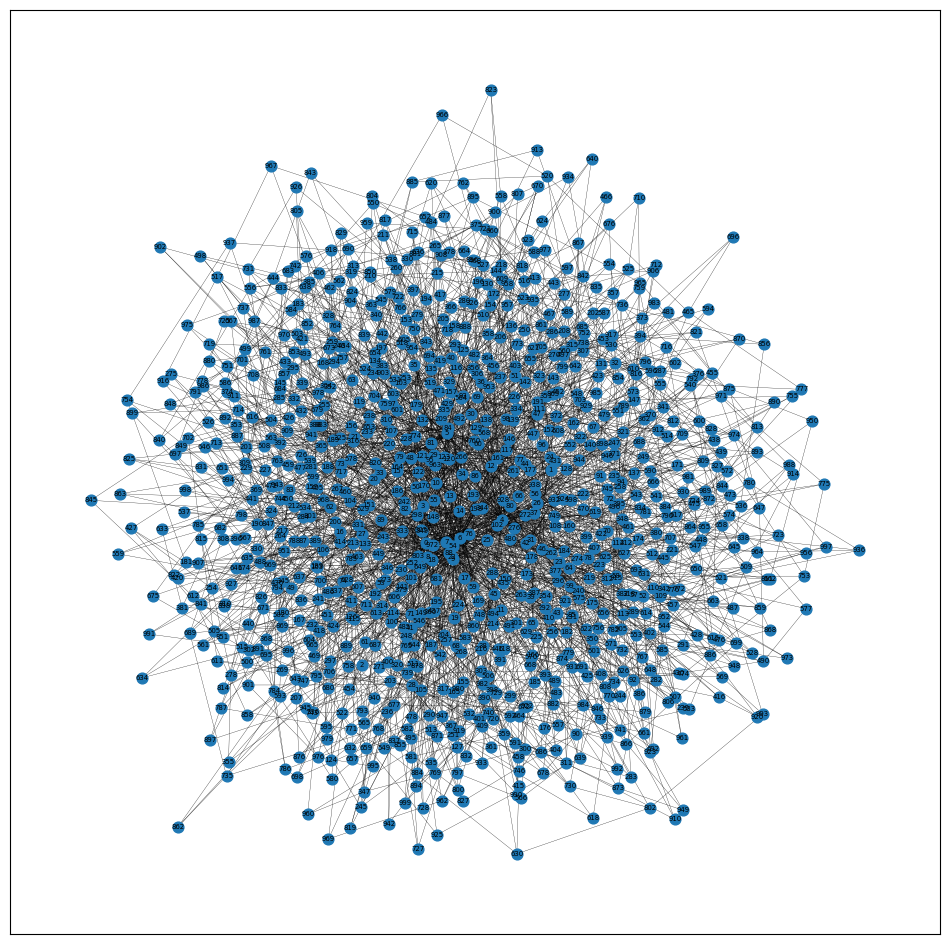

In [2]:
# N agents
N = 1000

# m possible opinion values 
m = 3

# Maximum global time T
T = 500 * N

# Social network G (static by default), adjacency matrix
# d number of edges to attach from a new node to existing nodes
d = 3
Gr = nx.barabasi_albert_graph(N, d, seed=42)

G = nx.to_scipy_sparse_array(Gr)

print("Graph density = {} %.".format(nx.density(Gr) * 100))
print(G.todense().shape)
print(G.todense()[0])
#nx.draw_networkx(Gr, pos=nx.spring_layout(Gr, seed=42, k=1))
plt.figure(figsize=(12,12))
nx.draw_networkx(Gr, node_size=60,font_size=5, width=0.2, pos=nx.spring_layout(Gr, seed=42))

plt.show()


In [3]:
# Transition matrix
P = np.zeros((3, 3, 3))

# Use this P matrix
P[0] = np.array([[0.96, 0.04, 0.0], [0.942, 0.057, 0.001], [0.907, 0.091, 0.002]])

#P[1] = np.array([[0.039, 0.952, 0.008], [0.021, 0.969, 0.01], [0.02, 0.944, 0.036]])
# Fix stochasticity
P[1] = np.array([[0.039, 0.953, 0.008], [0.021, 0.969, 0.01], [0.02, 0.944, 0.036]])

P[2] = np.array([[0.001, 0.082, 0.917], [0.001, 0.07, 0.929], [0.001, 0.054, 0.945]])

In [4]:
P[0][0][0]

0.96

In [5]:
#Check : row stochasticity
for i in range(len(P)): 
    print(np.sum(P[i], axis=1))

[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]


In [96]:
"""
P[0] = np.array([[0.9, 0.1, 0.0], [0.855, 0.143, 0.002], [0.768, 0.228, 0.004]])
P[1] = np.array([[0.024, 0.971, 0.005], [0.013, 0.981, 0.006],[0.012, 0.966, 0.022]])
P[2] = np.array([[0.001, 0.064, 0.935], [0.001, 0.054, 0.945], [0.001, 0.042, 0.957]])
"""

In [97]:
"""
#Check : row stochasticity
for i in range(len(P)): 
    print(np.sum(P[i], axis=1))
"""

[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]


In [6]:
# MODEL LOG
# Opinion trajectories : o[t][i] in X = {x1, x2, .., xm}, t = [0, T-1], i = [O, N-1]
o = np.zeros((T+1, N), dtype=int)


# Initialize random opinion vector
o[0] = np.random.choice(m, N)

# CHANGE here for initial opinion distribution
# o[0] = ...

# Populations of camps : Y[t][k] in [0, N]
Y = np.zeros((T+1, m), dtype=int)
_, Y[0] = np.unique(o[0], return_counts=True)

influences = []


In [7]:
# Random initial opinion vector
print(o[0])

[2 2 1 0 2 1 2 0 1 0 2 1 2 0 0 1 1 0 1 0 0 2 0 1 0 2 1 0 2 0 0 0 0 2 1 1 1
 0 2 2 0 2 0 1 1 0 0 1 1 1 0 0 2 2 2 2 1 1 0 2 0 2 1 1 0 2 1 2 1 2 1 0 0 2
 1 0 1 1 2 1 2 2 1 2 1 1 1 1 0 0 0 2 2 2 1 1 1 2 0 1 2 1 1 0 2 0 2 1 0 2 1
 0 2 1 0 1 0 0 2 2 1 1 0 1 1 2 2 2 1 0 0 2 1 2 1 0 0 2 2 1 1 1 2 0 0 0 1 2
 0 0 0 2 1 0 2 2 1 2 0 0 2 0 0 1 1 1 2 0 0 2 1 0 1 1 2 1 0 2 1 2 1 0 2 2 2
 1 1 2 2 0 2 2 2 0 1 1 0 0 1 2 2 0 0 2 0 0 2 2 2 1 1 1 0 1 0 2 0 0 0 2 1 2
 1 2 1 1 0 0 2 2 2 0 2 1 2 2 2 1 0 1 2 1 0 1 0 1 0 0 0 1 1 0 1 1 2 0 0 2 0
 0 2 2 0 1 0 1 1 1 1 2 2 1 1 0 1 0 2 1 1 1 1 0 1 2 0 0 2 0 0 1 1 1 2 1 1 1
 0 2 1 1 1 0 1 2 1 0 2 0 0 0 1 1 0 0 2 1 1 1 2 1 2 0 2 2 0 2 0 0 0 0 1 0 2
 2 1 2 2 2 2 1 2 0 1 2 2 2 0 2 0 0 2 2 1 2 1 2 2 0 2 1 0 2 1 0 0 1 1 1 1 1
 1 2 2 1 0 0 2 0 1 1 0 1 2 1 2 1 0 0 2 0 1 0 0 1 1 1 0 0 2 2 2 2 0 1 2 0 1
 1 0 0 0 0 0 0 1 0 1 0 0 2 0 0 1 2 0 1 2 2 2 2 2 2 0 1 0 1 1 1 1 1 1 0 1 0
 1 1 2 0 2 2 2 2 2 0 1 1 0 2 1 2 2 2 2 0 2 0 0 2 0 0 0 1 0 1 1 2 1 0 1 2 2
 2 0 1 2 2 0 1 2 1 0 0 0 

In [8]:
# Setting node colors to represent initial opinions
node_colors = ["tab:blue" if opinion==0 else "tab:grey" if opinion==1 else "tab:red" for opinion in o[0]]

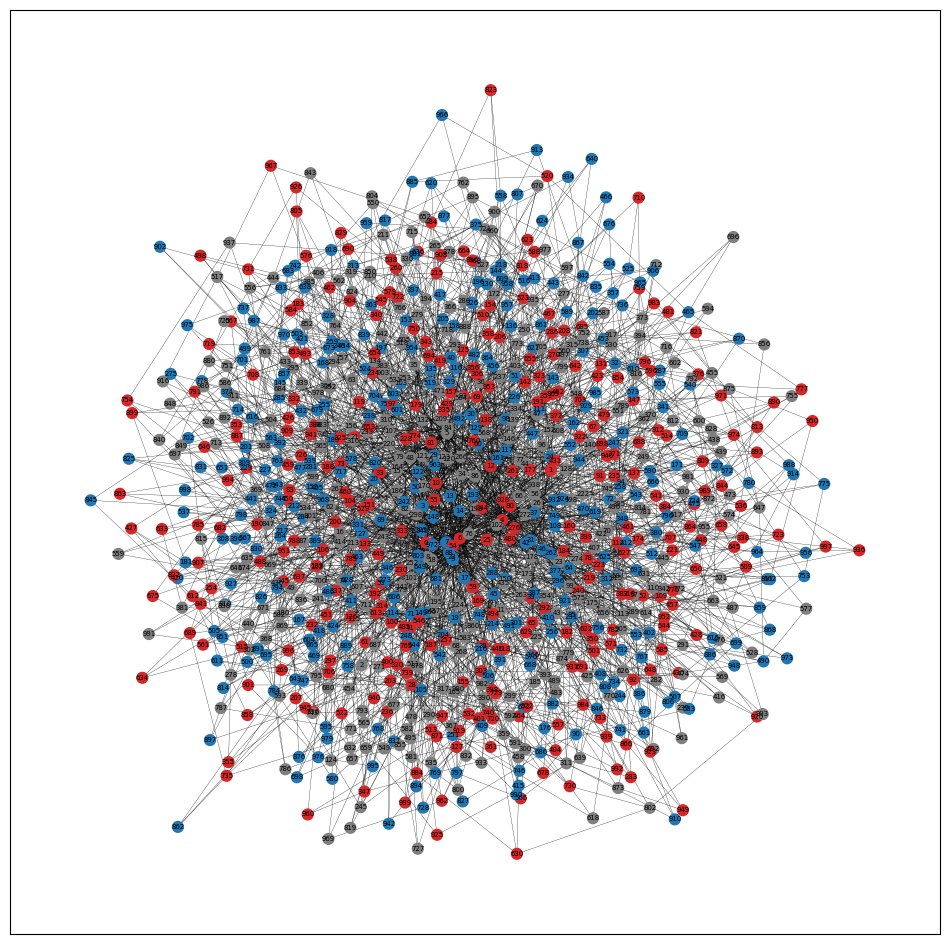

In [9]:
plt.figure(figsize=(12,12))

#fixed layout seed - fixed graph drawing
pos=nx.spring_layout(Gr, seed=42)

nx.draw_networkx(Gr, node_size=60, node_color=node_colors,font_size=5, width=0.2, pos=pos)
plt.show()

In [10]:
def model(T, N, Gr, G, m, P, o, Y, influences, verbose=False, plot=False): #nodes colors are for m = 3
    # Node positions if plot=True
    if plot:
        pos = nx.spring_layout(Gr, seed=42)
    # Run model
    for t in tqdm(range(T)):
        # Draw graph at the begging of the time step if plot=True
        if (plot==True) & (t % 50000 == 0):
            clear_output(wait=True)
            node_colors = ["tab:blue" if opinion==0 else "tab:grey" if opinion==1 else "tab:red" for opinion in o[t]]
            plt.figure(figsize=(12,12))
            nx.draw_networkx(Gr, node_size=60, node_color=node_colors, font_size=5, width=0.2, pos=pos)
            plt.show()

        # Random agent i
        agent = np.random.choice(N)
        agent_opinion = o[t][agent]

        # ver1
        # neighbors = np.nonzero(np.array(G.todense()[agent])[0])[0]
        # ver2
        neighbors = G.indices[G.indptr[agent]:G.indptr[agent+1]]

        # Random agent j
        neighbor = np.random.choice(neighbors)
        neighbor_opinion = o[t][neighbor]

        # Influence 
        new_agent_op = np.random.choice(m, p=P[agent_opinion][neighbor_opinion])

        # Model log for the beging of the next time step
        # Copying
        o[t+1] = o[t].copy()
        Y[t+1] = Y[t].copy()
        # Influence during the time step t
        o[t+1][agent] = new_agent_op
        Y[t+1][agent_opinion] -= 1
        Y[t+1][new_agent_op] += 1

        infl = (agent, agent_opinion, neighbor, neighbor_opinion, new_agent_op)
        influences.append(infl)

        if verbose:
            print("At time step {}: {}.".format(t, infl))
    

### Convergence ?

In [33]:
#del o_test, Y_test, y_test
gc.collect()

67444

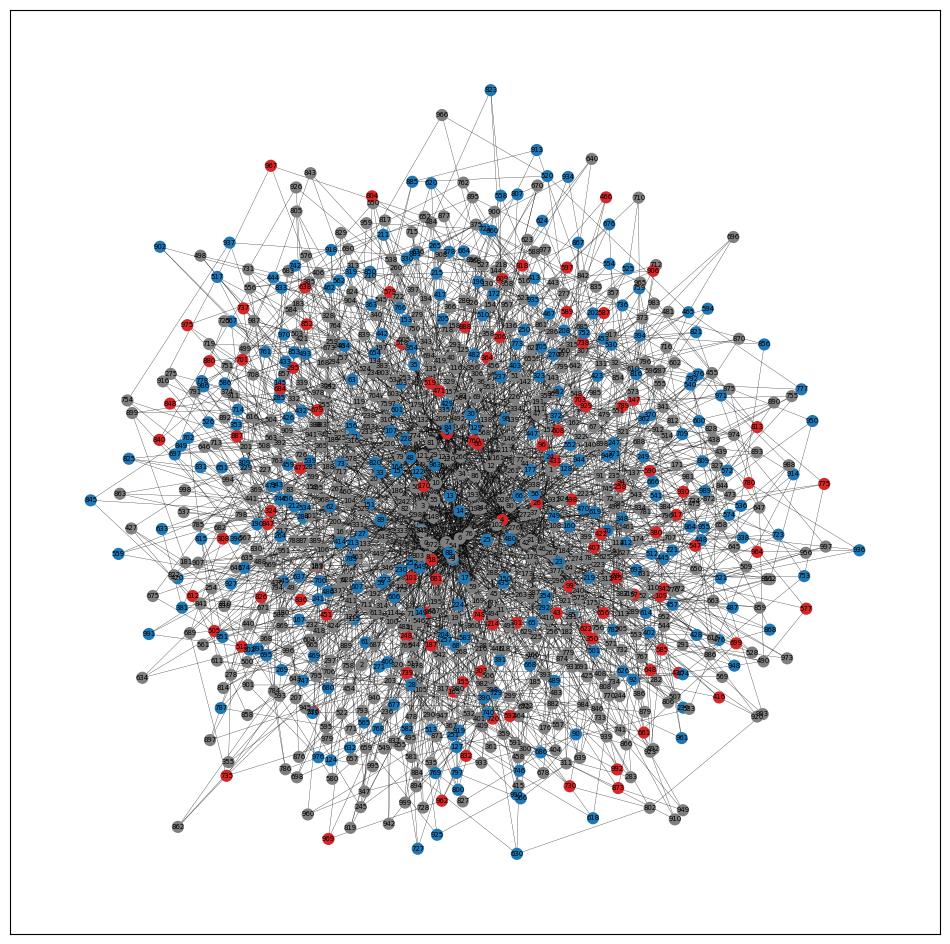

100%|██████████| 500000/500000 [00:44<00:00, 11162.65it/s]


In [11]:
T_test = T

# Init model
o_test = np.zeros((T_test+1, N), dtype=int)
o_test[0] = np.random.choice(m, N)

Y_test = np.zeros((T_test+1, m), dtype=int)
_, Y_test[0] = np.unique(o[0], return_counts=True)

infls_test = []

# Test model
model(T_test, N, Gr, G, m, P, o_test, Y_test, infls_test, plot=True)

100%|██████████| 50000/50000 [08:59<00:00, 92.62it/s] 
/tmp/ipykernel_20991/792862047.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


NameError: name 'os' is not defined

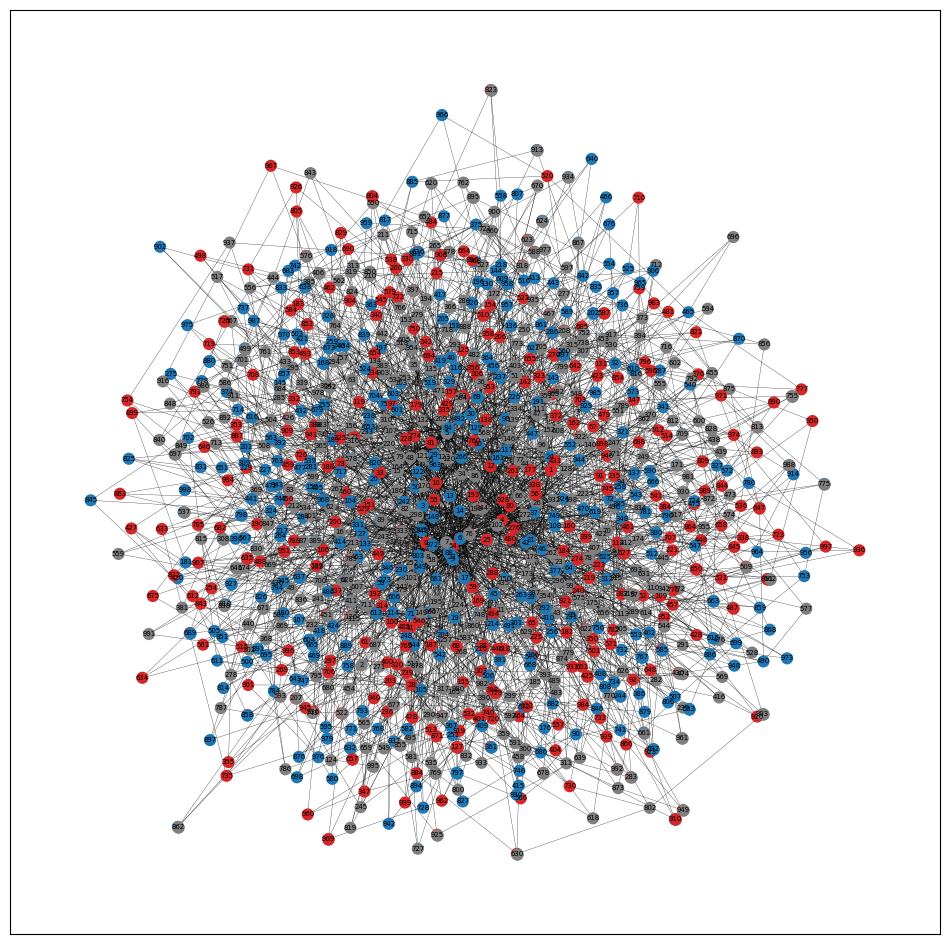

In [30]:
node_colors = ["tab:blue" if opinion==0 else "tab:grey" if opinion==1 else "tab:red" for opinion in o[0]]
plt.figure(figsize=(12,12))
nx.draw_networkx(Gr, node_size=60, node_color=node_colors, font_size=5, width=0.2, pos=pos)

ax = plt.gca()
"""
for infl in infls_test[:1]:
    new_node_color = "tab:blue" if infl[4]==0 else "tab:grey" if infl[4]==1 else "tab:red"
    ax.add_collection(nx.draw_networkx_nodes(Gr, nodelist=[infl[0]], node_size=60, node_color=new_node_color, pos=pos))
plt.show()
"""

filenames = []
i=0

for t in tqdm(range(len(infls_test[:50000]))):
    infl = infls_test[t]
    if infl[1] != infl[4]:
        i+=1
        if i % 10 == 0:
            new_node_color = "tab:blue" if infl[4]==0 else "tab:grey" if infl[4]==1 else "tab:red"
            ax.add_collection(nx.draw_networkx_nodes(Gr, nodelist=[infl[0]], node_size=60, node_color=new_node_color, pos=pos))
            
            # create file name and append it to a list
            filename = f'{i}.png'
            filenames.append(filename)
            
            # save frame
            plt.savefig(filename)
    
# build gif
with imageio.get_writer('test.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [20]:
o_test[10:], Y_test[10:], o_test[:-10], Y_test[:-10]

(array([[1, 0, 2, ..., 2, 1, 0],
        [1, 0, 2, ..., 2, 1, 0],
        [1, 0, 2, ..., 2, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1]]),
 array([[345, 340, 315],
        [345, 341, 314],
        [345, 341, 314],
        ...,
        [339, 605,  56],
        [339, 605,  56],
        [339, 605,  56]]),
 array([[1, 0, 2, ..., 2, 1, 0],
        [1, 0, 2, ..., 2, 1, 0],
        [1, 0, 2, ..., 2, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1]]),
 array([[346, 339, 315],
        [346, 339, 315],
        [346, 339, 315],
        ...,
        [339, 605,  56],
        [339, 605,  56],
        [339, 605,  56]]))

In [95]:
print(len(infls_test))
print(infls_test[:10])

500000
[(829, 2, 246, 2, 2), (297, 0, 486, 2, 0), (556, 1, 576, 2, 1), (188, 1, 328, 0, 1), (479, 2, 594, 1, 2), (224, 0, 836, 1, 0), (356, 2, 7, 1, 2), (744, 0, 13, 1, 0), (496, 0, 253, 2, 0), (422, 2, 3, 1, 2)]


In [96]:
y_test = Y_test / N
y_test[:10]

array([[0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326],
       [0.321, 0.353, 0.326]])

In [97]:
print(np.sum(y_test, axis=1)[:100])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


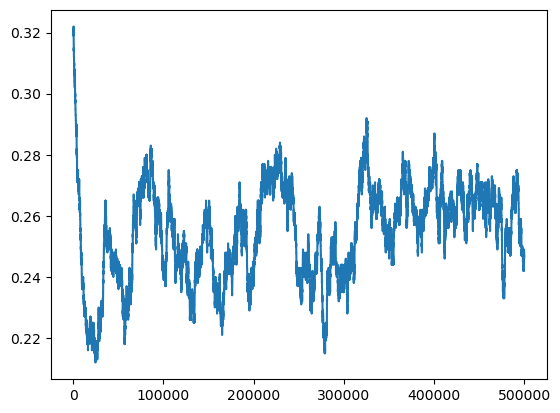

In [98]:
plt.plot(y_test[:, 0])

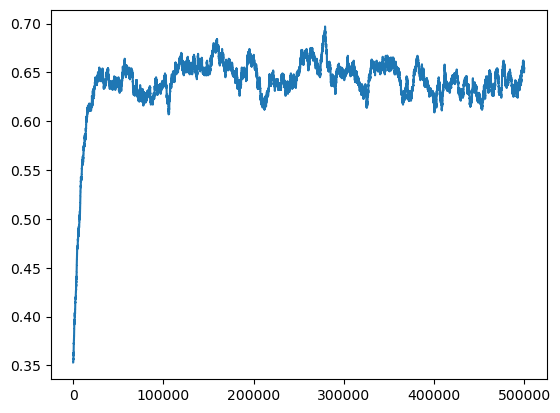

In [99]:
plt.plot(y_test[:, 1])

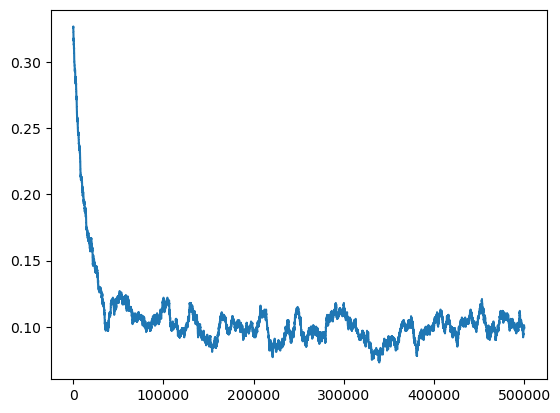

In [100]:
plt.plot(y_test[:, 2])